In [1]:
import numpy as np
import os
from codeStore import support_fun as spf
import importlib
from matplotlib import pyplot as plt

PWD = os.getcwd()

In [2]:
def write_pbs_head(fpbs, job_name):
    fpbs.write('#! /bin/bash\n')
    fpbs.write('#PBS -M zhangji@csrc.ac.cn\n')
    fpbs.write('#PBS -l nodes=1:ppn=24\n')
    fpbs.write('#PBS -l walltime=72:00:00\n')
    fpbs.write('#PBS -q common\n')
    fpbs.write('#PBS -N %s\n' % job_name)
    fpbs.write('\n')
    fpbs.write('cd $PBS_O_WORKDIR\n')
    fpbs.write('\n')
    

In [23]:
# case 1, traverse all parameters, inf space
maxtheta_list = [10, 50, 100, 500, 1000, 5000, 10000, 50000]
nphi_list = [100, 500, 1000, 5000, 10000, 20000]
nthfct_list = [1, 10, 100]  # nth = nthfct * maxtheta
job_dir = 'infhlx_20180510'
if not os.path.exists(job_dir):
    os.makedirs(job_dir)

t_name = os.path.join(job_dir, 'run.sh')
with open(t_name, 'w') as frun:
    # create .pbs file
    for maxtheta in maxtheta_list:
        for nphi in nphi_list:
            for nthfct in nthfct_list:
                nth = nthfct * maxtheta
                job_name = 'infhlx%06d_%06d_%04d' % (maxtheta, nphi, nthfct)
                t_name = os.path.join(job_dir, '%s.pbs' % job_name)
                with open(t_name, 'w') as fpbs:
                    write_pbs_head(fpbs, job_name)
                    fpbs.write('mpirun -n 24 python ')
                    fpbs.write(' ../try_infhelix.py ')
                    fpbs.write(' -infhelix_maxtheta %f ' % maxtheta)
                    fpbs.write(' -infhelix_nnode %f ' % nphi)
                    fpbs.write(' -infhelix_ntheta %f ' % nth)
                    fpbs.write(' > %s.txt' % job_name)
                
    # write to .sh file
                    frun.write('qsub %s.pbs\n' % job_name)
    
    frun.write('\n')

In [37]:
# case 2, maxtheta varing, inf space
maxtheta_list = 10 ** np.arange(1, 8)
nphi_list = [100, ]
nthfct_list = [30, ]  # nth = nthfct * maxtheta
job_dir = 'infhlx_20180511'
if not os.path.exists(job_dir):
    os.makedirs(job_dir)

t_name = os.path.join(job_dir, 'run.sh')
with open(t_name, 'w') as frun:
    # create .pbs file
    for maxtheta in maxtheta_list:
        for nphi in nphi_list:
            for nthfct in nthfct_list:
                nth = nthfct * maxtheta
                job_name = 'infhlx_maxtheta1E%02d' % np.log10(maxtheta)
                t_name = os.path.join(job_dir, '%s.pbs' % job_name)
                with open(t_name, 'w') as fpbs:
                    write_pbs_head(fpbs, job_name)
                    fpbs.write('mpirun -n 24 python ')
                    fpbs.write(' ../try_infhelix.py ')
                    fpbs.write(' -infhelix_maxtheta %f ' % maxtheta)
                    fpbs.write(' -infhelix_nnode %f ' % nphi)
                    fpbs.write(' -infhelix_ntheta %f ' % nth)
                    fpbs.write(' -ksp_max_it 1000')
                    fpbs.write(' > %s.txt' % job_name)
                    # write to .sh file
                    frun.write('qsub %s.pbs\n' % job_name)
    
    frun.write('\n')


In [61]:
# case 3, comparation with Liu Bin
#  helical swimming in stokes flow using a novel boundary-element method
#    Fig 5
a_tao = [(0.013, 'a'), (0.026, 'b')]
nth = 500
ch = 40
infhelix_ntheta = ch * 500
rh1 = 1
job_dir = 'compare_Liu'
if not os.path.exists(job_dir):
    os.makedirs(job_dir)

for ta, idx in a_tao:
    job_dir2 = os.path.join(job_dir, 'bFig_5_%s' % idx)
    if not os.path.exists(job_dir2):
        os.makedirs(job_dir2)
        
    t_name = os.path.join(job_dir2, 'run.sh')
    with open(t_name, 'w') as frun:
        # helix angle, tan(theta)=(2*pi*R)/ph
        for theta in np.linspace(0, np.pi / 2, 30)[1:]:
            rh2 = ta * 2 * np.pi * rh1 / np.sin(theta)
            ph = 2 * np.pi * rh1 / np.tan(theta)
            job_name = 'theta_%4.2f' % theta
            t_name = os.path.join(job_dir2, '%s.pbs' % job_name)
            with open(t_name, 'w') as fpbs:
                write_pbs_head(fpbs, job_name)
                fpbs.write('mpirun -n 24 python ')
                fpbs.write(' ../../try_infhelix.py ')
                fpbs.write(' -nth %d ' % nth)
                fpbs.write(' -ch %f ' % ch)
                fpbs.write(' -ph %f ' % ph)
                fpbs.write(' -rh1 %f ' % rh1)
                fpbs.write(' -rh2 %f ' % rh2)
                fpbs.write(' -infhelix_ntheta %d ' % infhelix_ntheta)
                fpbs.write(' -ksp_max_it 1000')
                fpbs.write(' > %s.txt' % job_name)
                # write to .sh file
                frun.write('qsub %s.pbs\n' % job_name)
        frun.write('\n')




In [8]:
# case 4, comparation with Liu Bin
#  Propulsion by a helical flagellum in a capillary tube
#    Fig 2a
a_tao = 0.013
nth = 100
ch = 50
eh = -1
rh1 = 1
n_tail = 1
theta_list = np.arange(0.032, 0.5, 0.032 * 3)
zmfct_list = np.linspace(0.1, 1, 9, endpoint=False)
dbg_mode = False

job_dir = 'compare_Liu'
if not os.path.exists(job_dir):
    os.makedirs(job_dir)
job_dir2 = os.path.join(job_dir, 'eFig_2_a')
if not os.path.exists(job_dir2):
    os.makedirs(job_dir2)

t_name = os.path.join(job_dir2, 'run.sh')
with open(t_name, 'w') as frun:
    # helix angle, tan(theta)=(2*pi*R)/ph
    for theta in theta_list:
        job_name = 'theta_%4.2f' % theta
        t_name = os.path.join(job_dir2, '%s.pbs' % job_name)
        rh2 = a_tao * 2 * np.pi * rh1 / np.sin(theta * np.pi)
        ph = 2 * np.pi * rh1 / np.tan(theta * np.pi)
        with open(t_name, 'w') as fpbs:
            write_pbs_head(fpbs, job_name)
            # infHelix without tube
            fpbs.write('mpirun -n 24 python ')
            if dbg_mode:
                fpbs.write(' ../try_infhelix.py ')
                fpbs.write(' -plot_geo 1 ')
            else:
                fpbs.write(' ../../try_infhelix.py ')
            fpbs.write(' -nth %d ' % nth)
            fpbs.write(' -ch %f ' % ch)
            fpbs.write(' -ph %f ' % ph)
            fpbs.write(' -eh %f ' % eh)
            fpbs.write(' -rh1 %f ' % rh1)
            fpbs.write(' -rh2 %f ' % rh2)
            fpbs.write(' -n_tail %d ' % n_tail)
            fpbs.write(' -ksp_max_it 100')
            fpbs.write(' > %s_%s.txt\n\n' % (job_name, 'inf'))
            # infHelix in tube
            for zoom_factor in zmfct_list:
                fpbs.write('mpirun -n 24 python ')
                if dbg_mode:
                    fpbs.write(' ../helixInPipe.py ')
                    fpbs.write(' -plot_geo 1 ')
                else:
                    fpbs.write(' ../../helixInPipe.py ')
                fpbs.write(' -nth %d ' % nth)
                fpbs.write(' -ch %f ' % ch)
                fpbs.write(' -ph %f ' % ph)
                fpbs.write(' -eh %f ' % eh)
                fpbs.write(' -rh1 %f ' % rh1)
                fpbs.write(' -rh2 %f ' % rh2)
                fpbs.write(' -n_tail %d ' % n_tail)
                fpbs.write(' -ksp_max_it 100')
                fpbs.write(' -zoom_factor %f' % zoom_factor)
                fpbs.write(' > %s_%4.2f.txt\n\n' % (job_name, zoom_factor))
            # write to .sh file
            frun.write('qsub %s.pbs\n' % job_name)
    frun.write('\n')




In [94]:
# case 4, comparation with Liu Bin, each case generate a qsub file separately. 
#  Propulsion by a helical flagellum in a capillary tube
#    Fig 2a
a_tao = 0.013
nth = 200
ch = 100
eh = -1
infhelix_ntheta = ch * 300
rh1 = 1
n_tail = 1
theta_list = np.arange(0.032, 0.5, 0.032)
zmfct_list = np.linspace(0.1, 1, 30, endpoint=False)
dbg_mode = False

job_dir = 'compare_Liu'
if not os.path.exists(job_dir):
    os.makedirs(job_dir)
job_dir2 = os.path.join(job_dir, 'dFig_2_a')
if not os.path.exists(job_dir2):
    os.makedirs(job_dir2)

t_name = os.path.join(job_dir2, 'run.sh')
with open(t_name, 'w') as frun:
    frun.write('t_dir=$PWD\n')

    # helix angle, tan(theta)=(2*pi*R)/ph
    for theta in theta_list:
        job_dir3 = os.path.join(job_dir2, 'theta_%4.2f' % theta)
        if not os.path.exists(job_dir3):
            os.makedirs(job_dir3)
        rh2 = a_tao * 2 * np.pi * rh1 / np.sin(theta * np.pi)
        ph = 2 * np.pi * rh1 / np.tan(theta * np.pi)
        
        t_name = os.path.join(job_dir3, 'run.sh')
        with open(t_name, 'w') as frun2:
            # infHelix without tube
            job_name = 'theta_%4.2f_inf' % (theta)
            t_name = os.path.join(job_dir3, '%s.pbs' % job_name)
            with open(t_name, 'w') as fpbs:
                write_pbs_head(fpbs, job_name)
                fpbs.write('mpirun -n 24 python ')
                if dbg_mode:
                    fpbs.write(' ../try_infhelix.py ')
                    fpbs.write(' -plot_geo 1 ')
                else:
                    fpbs.write(' ../../../try_infhelix.py ')
                fpbs.write(' -nth %d ' % nth)
                fpbs.write(' -ch %f ' % ch)
                fpbs.write(' -ph %f ' % ph)
                fpbs.write(' -eh %f ' % eh)
                fpbs.write(' -rh1 %f ' % rh1)
                fpbs.write(' -rh2 %f ' % rh2)
                fpbs.write(' -n_tail %d ' % n_tail)
                fpbs.write(' -infhelix_ntheta %d ' % infhelix_ntheta)
                fpbs.write(' -ksp_max_it 1000')
                fpbs.write(' > %s_%s.txt\n\n' % (job_name, 'inf'))
                # write to .sh file
                frun2.write('qsub %s.pbs\n' % job_name)

            # infHelix in tube
            for zoom_factor in zmfct_list:
                job_name = 'theta_%4.2f_%4.2f' % (theta, zoom_factor)
                t_name = os.path.join(job_dir3, '%s.pbs' % job_name)
                with open(t_name, 'w') as fpbs:
                    write_pbs_head(fpbs, job_name)
                    fpbs.write('mpirun -n 24 python ')
                    if dbg_mode:
                        fpbs.write(' ../helixInPipe.py ')
                        fpbs.write(' -plot_geo 1 ')
                    else:
                        fpbs.write(' ../../../helixInPipe.py ')
                    fpbs.write(' -nth %d ' % nth)
                    fpbs.write(' -ch %f ' % ch)
                    fpbs.write(' -ph %f ' % ph)
                    fpbs.write(' -eh %f ' % eh)
                    fpbs.write(' -rh1 %f ' % rh1)
                    fpbs.write(' -rh2 %f ' % rh2)
                    fpbs.write(' -n_tail %d ' % n_tail)
                    fpbs.write(' -infhelix_ntheta %d ' % infhelix_ntheta)
                    fpbs.write(' -ksp_max_it 1000')
                    fpbs.write(' -zoom_factor %f' % zoom_factor)
                    fpbs.write(' > %s_%4.2f.txt\n\n' % (job_name, zoom_factor))
                    # write to .sh file
                    frun2.write('qsub %s.pbs\n' % job_name)
        frun.write('cd $t_dir/theta_%4.2f\n' % theta)
        frun.write('bash run.sh\n')
    frun.write('cd $t_dir\n')
    frun.write('\n')




In [3]:
# # case 5, dbg_theta_factor

# # dbg_theta_factor_list = np.linspace(-0.8, 0.8, 9)  # true theta: dbg_theta_factor * np.pi
# # job_dir = 'try_dbg_theta_factor'
# # chi = 5

# dbg_theta_factor_list = np.linspace(0, 0.8, 9)  # true theta: dbg_theta_factor * np.pi
# job_dir = 'try_dbg_theta_factor2'
# chi = 10

# if not os.path.exists(job_dir):
#     os.makedirs(job_dir)

# t_name = os.path.join(job_dir, 'run.sh')
# with open(t_name, 'w') as frun:
#     # create .pbs file
#     for dbg_theta_factor in dbg_theta_factor_list:
#         job_name = 'dbg_th_fct%f' % dbg_theta_factor
#         t_name = os.path.join(job_dir, '%s.pbs' % job_name)
#         with open(t_name, 'w') as fpbs:
#             write_pbs_head(fpbs, job_name)
#             fpbs.write('mpirun -n 24 python ')
#             fpbs.write(' ../helixInPipe.py ')
#             fpbs.write(' -ch %f ' % chi)
#             fpbs.write(' -rh1 %f ' % 0.2)
#             fpbs.write(' -rh2 %f ' % 0.05)
#             fpbs.write(' -ph %f ' % 1.26)
#             fpbs.write(' -eh %f ' % -1)
#             fpbs.write(' -nth %d ' % 100)
#             fpbs.write(' -zoom_factor %f ' % 0.5)
#             fpbs.write(' -dbg_theta_factor %f ' % dbg_theta_factor)
#             fpbs.write(' > %s.txt' % job_name)
            
#             # write to .sh file
#             frun.write('qsub %s.pbs\n' % job_name)
    
#     frun.write('\n')

################################################################################################################################


# case 5, dbg_theta_factor

dbg_theta_factor_list = np.linspace(0, 0.8, 9)  # true theta: dbg_theta_factor * np.pi
job_dir = 'try_dbg_theta_factor3'
chi = 10

importlib.reload(spf)
write_pbs_head = spf.write_pbs_head_newturb
if not os.path.exists(job_dir):
    os.makedirs(job_dir)

t_name = os.path.join(job_dir, 'run.sh')
with open(t_name, 'w') as frun:
    # create .pbs file
    job_name = 'dbg_th_fct%f' % dbg_theta_factor
    t_name = os.path.join(job_dir, '%s.pbs' % job_name)
    with open(t_name, 'w') as fpbs:
        write_pbs_head(fpbs, job_name)
        fpbs.write('mpirun -n 24 python ')
        fpbs.write(' ../helixInPipe.py ')
        fpbs.write(' -ch %f ' % chi)
        fpbs.write(' -rh1 %f ' % 1)
        fpbs.write(' -rh2 %f ' % 0.08)
        fpbs.write(' -ph %f ' % 10)
        fpbs.write(' -eh %f ' % -1)
        fpbs.write(' -nth %d ' % 100)
        fpbs.write(' -zoom_factor %f ' % 0.6)
        fpbs.write(' -dbg_theta_factor %f ' % 0)
        fpbs.write(' > %s.txt' % job_name)

        # write to .sh file
        frun.write('qsub %s.pbs\n' % job_name)
    
    frun.write('\n')

In [96]:
# case 6, compare 1d_inf method and pf_stokesletsInPipe method 

# dbg_theta_factor_list = np.linspace(0, 0.8, 9)  # true theta: dbg_theta_factor * np.pi
# job_dir = 'try_ckeckInf1'
# chi = 10

# importlib.reload(spf)
# # write_pbs_head = spf.write_pbs_head
# write_pbs_head = spf.write_pbs_head_newturb
# if not os.path.exists(job_dir):
#     os.makedirs(job_dir)

# t_name = os.path.join(job_dir, 'run.sh')
# with open(t_name, 'w') as frun:
#     # create .pbs file
#     for dbg_theta_factor in dbg_theta_factor_list:
#         job_name = 'dbg_th_fct%f' % dbg_theta_factor
#         t_name = os.path.join(job_dir, '%s.pbs' % job_name)
#         with open(t_name, 'w') as fpbs:
#             write_pbs_head(fpbs, job_name)
#             fpbs.write('mpirun -n 24 python ')
#             fpbs.write(' ../helixInPipe_U.py ')
#             fpbs.write(' -ch %f ' % chi)
#             fpbs.write(' -rh1 %f ' % 1)
#             fpbs.write(' -rh2 %f ' % 0.08)
#             fpbs.write(' -ph %f ' % 10)
#             fpbs.write(' -eh %f ' % -1)
#             fpbs.write(' -nth %d ' % 100)
#             fpbs.write(' -zoom_factor %f ' % 0.6)
#             fpbs.write(' -dbg_theta_factor %f ' % dbg_theta_factor)
#             fpbs.write(' > %s.txt' % job_name)
            
#             # write to .sh file
#             frun.write('qsub %s.pbs\n' % job_name)
    
#     frun.write('\n')
    
# ####################################################################################################################################

# # dbg_theta_factor_list = [0, ]  # true theta: dbg_theta_factor * np.pi
# # job_dir = 'try_ckeckInf2'
# # ph_list = [0.4,   0.7,   1.,    1.2,   1.9,   2.2,   2.5,   3.,    4.,    5.,    6.,    8.,   10.,   12.,   15.,   20., ]
# # ch_list = [10, ]
# # nth = 100

# # dbg_theta_factor_list = [0, ]  # true theta: dbg_theta_factor * np.pi
# # job_dir = 'try_ckeckInf2b'
# # ph_list = [0.4,   0.7,   1.,    1.2,   1.9,   2.2,   2.5,   3.,    4.,    5.,    6.,    8.,   10.,   12.,   15.,   20., ]
# # ch_list = [20, ]
# # nth = 100

# job_dir = 'try_ckeckInf2c'
# ph_list = [0.4,   0.7,   1.,    1.2,   1.9,   2.2,   2.5,   3.,    4.,    5.,    6.,    8.,   10.,   12.,   15.,   20., ]
# ch_list = [20, ]
# nth = 500
# n_tail = 2

# importlib.reload(spf)
# # write_pbs_head = spf.write_pbs_head
# write_pbs_head = spf.write_pbs_head
# if not os.path.exists(job_dir):
#     os.makedirs(job_dir)

# t_name = os.path.join(job_dir, 'run.sh')
# with open(t_name, 'w') as frun:
#     # create .pbs file
#     for dbg_theta_factor in dbg_theta_factor_list:
#         for chi in ch_list:
#             for phi in ph_list:
#                 job_name = 'ckeckInf_thFct%05.2f_ph%05.2f' % (dbg_theta_factor, phi)
#                 t_name = os.path.join(job_dir, '%s.pbs' % job_name)
#                 with open(t_name, 'w') as fpbs:
#                     write_pbs_head(fpbs, job_name)
#                     fpbs.write('mpirun -n 24 python ')
#                     fpbs.write(' ../helixInPipe_U.py ')
#                     fpbs.write(' -ch %f ' % chi)
#                     fpbs.write(' -rh1 %f ' % 1)
#                     fpbs.write(' -rh2 %f ' % 0.08)
#                     fpbs.write(' -ph %f ' % phi)
#                     fpbs.write(' -eh %f ' % -1)
#                     fpbs.write(' -nth %d ' % nth)
#                     fpbs.write(' -n_tail %d ' % n_tail)
#                     fpbs.write(' -ksp_max_it %d ' % 500)
#                     fpbs.write(' -zoom_factor %f ' % 0.6)
#                     fpbs.write(' > %s.txt' % job_name)

#                     # write to .sh file
#                     frun.write('qsub %s.pbs\n' % job_name)
    
#     frun.write('\n')

####################################################################################################################################
write_pbs_head = spf.write_pbs_head
# job_dir = 'try_ckeckInf2d'
# ph_list = np.array([0.7, 1., 1.2, 1.9, 2.2, 2.5, 3., 4., 5., 6., 8., 10., 12., 15., 20.,])
# r_max = 100
# ch_list = np.ceil(r_max / ph_list)
# nth_list = [200, 400, 600]
# zoom_factor_list = [0.2, 0.4, 0.6, ]
# n_tail = 2

# job_dir = 'try_ckeckInf2e'
# ph_list = np.array([0.4, 0.7, 1., 1.2, 1.9, 2.2, 2.5, 3., 4., 5., 6., 8., 10., 12., 15., 20.,])
# r_max = 20
# ch_list = np.ceil(r_max / ph_list)
# nth_list = [100, 200, 300]
# zoom_factor_list = [0.2, 0.4, 0.6, ]
# n_tail = 2
# write_pbs_head = spf.write_pbs_head_newturb

# job_dir = 'try_ckeckInf2f'
# ph_list = np.array([0.4, 0.7, 1., 1.2, 1.9, 2.2, 2.5, 3., 4., 5., 6., 8., 10., 12., 15., 20.,])
# r_max = 20
# ch_list = np.ceil(r_max / ph_list)
# nth_list = np.ceil(np.array([100, 200, 300, 350, 400]) / 2)
# zoom_factor_list = [0.2, 0.4, 0.6, 0.7, 0.8]
# n_tail = 2
# write_pbs_head = spf.write_pbs_head_newturb

# job_dir = 'try_ckeckInf2g'
# ph_list = np.array([0.4, 0.7, 1., 1.2, 1.9, 2.2, 2.5, 3., 4., 5., 6., 8., 10., 12., 15., 20.,])
# r_max = 20
# ch_list = np.ceil(r_max / ph_list)
# nth_list = np.ceil(np.array([100, 200, 300, 350, 400]) * 2)
# zoom_factor_list = np.array([0.2, 0.4, 0.6, 0.7, 0.8])
# n_tail = 2
# write_pbs_head = spf.write_pbs_head_q03

job_dir = 'try_ckeckInf2h'
ph_list = np.array([0.4, 0.7, 1., 1.2, 1.9, 2.2, 2.5, 3., ])
r_max = 40
ch_list = np.ceil(r_max / ph_list)
nth_list = np.ceil(np.array([100, 200, 300, 350, 400]) * 2)
zoom_factor_list = np.array([0.2, 0.4, 0.6, 0.7, 0.8])
n_tail = 2
write_pbs_head = spf.write_pbs_head_q03

importlib.reload(spf)
if not os.path.exists(job_dir):
    os.makedirs(job_dir)

t_name = os.path.join(job_dir, 'run.sh')
with open(t_name, 'w') as frun:
    # create .pbs file, infhelix_U
    for chi, phi in zip(ch_list, ph_list):
        job_name = 'ckeckInf_zf%04.2f_ph%05.2f' % (0, phi)
        t_name = os.path.join(job_dir, '%s.pbs' % job_name)
        with open(t_name, 'w') as fpbs:
            write_pbs_head(fpbs, job_name)                
            fpbs.write('mpirun -n 24 python ')
            fpbs.write(' ../infhelix_U.py ')
            fpbs.write(' -ch %d ' % int(chi * 4))
            fpbs.write(' -rh1 %f ' % 1)
            fpbs.write(' -rh2 %f ' % 0.08)
            fpbs.write(' -ph %f ' % phi)
            fpbs.write(' -eh %f ' % -1)
            fpbs.write(' -nth %d ' % 100)
            fpbs.write(' -n_tail %d ' % n_tail)
            fpbs.write(' -ksp_max_it %d ' % 500)
            fpbs.write(' -zoom_factor %f ' % 0)
            fpbs.write(' > %s.txt' % job_name)
            # write to .sh file
            frun.write('qsub %s.pbs\n' % job_name)
    
    # create .pbs file, helixInPipe_U
    for chi, phi in zip(ch_list, ph_list):
        for zoom_factor, nth in zip(zoom_factor_list, nth_list):
            job_name = 'ckeckInf_zf%04.2f_ph%05.2f' % (zoom_factor, phi)
            t_name = os.path.join(job_dir, '%s.pbs' % job_name)
            with open(t_name, 'w') as fpbs:
                write_pbs_head(fpbs, job_name)
                fpbs.write('mpirun -n 24 python ')
                fpbs.write(' ../helixInPipe_U.py ')
                fpbs.write(' -ch %d ' % int(chi))
                fpbs.write(' -rh1 %f ' % 1)
                fpbs.write(' -rh2 %f ' % 0.08)
                fpbs.write(' -ph %f ' % phi)
                fpbs.write(' -eh %f ' % -1)
                fpbs.write(' -nth %d ' % nth)
                fpbs.write(' -n_tail %d ' % n_tail)
                fpbs.write(' -ksp_max_it %d ' % 500)
                fpbs.write(' -zoom_factor %f ' % zoom_factor)
                fpbs.write(' > %s.txt' % job_name)
                # write to .sh file
                frun.write('qsub %s.pbs\n' % job_name)
    frun.write('\n')
    

In [34]:
# case 4, comparation with Liu Bin, each case generate a qsub file separately. 
#  Propulsion by a helical flagellum in a capillary tube
#    Fig 2a

# a_tao = 0.013
# ch = 10
# rh1 = 1
# eh = -1
# n_tail = 1
# theta_list = np.arange(0.032, 0.5, 0.032)[::3]
# zmfct_list = np.linspace(0.1, 0.9, 9)
# nth_list = 100 * np.ones_like(zmfct_list)
# nth_0 = 100
# dbg_mode = False
# job_dir = 'compare_Liu'
# job_dir2 = os.path.join(job_dir, 'fFig_2_a')

# a_tao = 0.013
# ch = 10
# rh1 = 1
# eh = -1
# n_tail = 1
# theta_list = np.arange(0.032, 0.5, 0.032)[::3]
# zmfct_list = np.linspace(0.1, 0.9, 9)
# nth_list = 1000 * zmfct_list
# nth_0 = 100
# dbg_mode = False
# job_dir = 'compare_Liu'
# job_dir2 = os.path.join(job_dir, 'gFig_2_a')

# a_tao = 0.013
# ch = 10
# rh1 = 1
# eh = -1
# n_tail = 1
# theta_list = np.arange(0.032, 0.5, 0.032)[::3]
# zmfct_list = np.linspace(0.1, 0.9, 9)
# nth_list = 2000 * zmfct_list
# nth_0 = 100
# dbg_mode = False
# job_dir = 'compare_Liu'
# job_dir2 = os.path.join(job_dir, 'hFig_2_a')

# a_tao = 0.013
# ch = 10
# rh1 = 1
# eh = -1
# n_tail = 1
# theta_list = np.arange(0.032, 0.5, 0.032)[::3]
# zmfct_list = np.linspace(0.1, 0.9, 9)
# nth_list = 500 * zmfct_list
# nth_0 = 100
# dbg_mode = False
# job_dir = 'compare_Liu'
# job_dir2 = os.path.join(job_dir, 'iFig_2_a')

a_tao = 0.013
ch = 30
rh1 = 1
eh = -1
n_tail = 1
theta_list = np.arange(0.032, 0.5, 0.032)[::3]
zmfct_list = np.linspace(0.1, 0.9, 9)
nth_list = 250 * zmfct_list
nth_0 = 100
dbg_mode = False
job_dir = 'compare_Liu'
job_dir2 = os.path.join(job_dir, 'jFig_2_a')

a_tao = 0.013
ch = 30
rh1 = 1
eh = -1
n_tail = 1
theta_list = np.arange(0.032, 0.5, 0.032)[::3]
zmfct_list = np.linspace(0.1, 0.9, 9)
nth_list = 125 * zmfct_list
nth_0 = 100
dbg_mode = False
job_dir = 'compare_Liu'
job_dir2 = os.path.join(job_dir, 'kFig_2_a')

if not os.path.exists(job_dir):
    os.makedirs(job_dir)
if not os.path.exists(job_dir2):
    os.makedirs(job_dir2)

def write_case4_info(fpbs, nthi):
    fpbs.write(' -ch %f ' % ch)
    fpbs.write(' -ph %f ' % ph)
    fpbs.write(' -eh %f ' % eh)
    fpbs.write(' -rh1 %f ' % rh1)
    fpbs.write(' -rh2 %f ' % rh2)
    fpbs.write(' -nth %d ' % nthi)
    fpbs.write(' -n_tail %d ' % n_tail)
    fpbs.write(' -ksp_max_it 1000')
    
t_name = os.path.join(job_dir2, 'run.sh')
with open(t_name, 'w') as frun:
    frun.write('t_dir=$PWD\n')
    # helix angle, tan(theta)=(2*pi*R)/ph
    for theta in theta_list:
        job_dir3 = os.path.join(job_dir2, 'theta_%4.2f' % theta)
        if not os.path.exists(job_dir3):
            os.makedirs(job_dir3)
        rh2 = a_tao * 2 * np.pi * rh1 / np.sin(theta * np.pi)
        ph = 2 * np.pi * rh1 / np.tan(theta * np.pi)
        
        t_name = os.path.join(job_dir3, 'run.sh')
        with open(t_name, 'w') as frun2:
            # infHelix without tube
            job_name = 'theta_%4.2f_inf' % (theta)
            t_name = os.path.join(job_dir3, '%s.pbs' % job_name)
            with open(t_name, 'w') as fpbs:
                write_pbs_head(fpbs, job_name)
                fpbs.write('mpirun -n 24 python ')
                if dbg_mode:
                    fpbs.write(' ../infhelix_U.py ')
                    fpbs.write(' -plot_geo 1 ')
                else:
                    fpbs.write(' ../../../infhelix_U.py ')
                write_case4_info(fpbs, nth_0)
                fpbs.write(' > %s_%s.txt\n\n' % (job_name, 'inf'))
                # write to .sh file
                frun2.write('qsub %s.pbs\n' % job_name)

            # infHelix in tube
            for nthi, zoom_factor in zip(nth_list, zmfct_list):
                job_name = 'theta_%4.2f_%4.2f' % (theta, zoom_factor)
                t_name = os.path.join(job_dir3, '%s.pbs' % job_name)
                with open(t_name, 'w') as fpbs:
                    write_pbs_head(fpbs, job_name)
                    fpbs.write('mpirun -n 24 python ')
                    if dbg_mode:
                        fpbs.write(' ../helixInPipe_U.py ')
                        fpbs.write(' -plot_geo 1 ')
                    else:
                        fpbs.write(' ../../../helixInPipe_U.py ')
                    write_case4_info(fpbs, nthi)
                    fpbs.write(' -zoom_factor %f' % zoom_factor)
                    fpbs.write(' > %s_%4.2f.txt\n\n' % (job_name, zoom_factor))
                    # write to .sh file
                    frun2.write('qsub %s.pbs\n' % job_name)
        frun.write('cd $t_dir/theta_%4.2f\n' % theta)
        frun.write('bash run.sh\n')
    frun.write('cd $t_dir\n')
    frun.write('\n')




In [58]:
# # case 4, comparation with Liu Bin, each case generate a qsub file separately. 
# #  Propulsion by a helical flagellum in a capillary tube
# #    Fig 2a
# # varying the nodes on the helix smartly. Let the # of nodes on the pipe is a constant, 
# #     nodes on helix is a combination linear functions of zf and rh2. 

# # a_tao = 0.013
# # ch = 20
# # rh1 = 1
# # eh = -1
# # n_tail = 1
# # theta_list = np.arange(0.032, 0.5, 0.032)[::3]
# # zmfct_list = np.hstack((np.linspace(0.1, 0.8, 8), np.linspace(0.82, 0.98, 9)))
# # nth_fct = [500, 2000]
# # dbg_mode = False
# # job_dir = 'compare_Liu'
# # job_dir2 = os.path.join(job_dir, 'lFig_2_a')

# # a_tao = 0.013
# # ch = 10
# # rh1 = 1
# # eh = -1
# # n_tail = 1
# # theta_list = np.arange(0.032, 0.5, 0.032)[::3]
# # zmfct_list = np.hstack((np.linspace(0.1, 0.8, 8), np.linspace(0.82, 0.98, 9)))
# # nth_fct = [400, 1500]
# # dbg_mode = False
# # job_dir = 'compare_Liu'
# # job_dir2 = os.path.join(job_dir, 'mFig_2_a')

# a_tao = 0.013
# ch = 10
# rh1 = 1
# eh = -1
# n_tail = 1
# theta_list = np.arange(0.032, 0.5, 0.032)[::3]
# zmfct_list = np.hstack((np.linspace(0.1, 0.8, 8), np.linspace(0.82, 0.98, 9)))
# nth_fct = [400, 1500]
# dbg_mode = False
# job_dir = 'compare_Liu'
# job_dir2 = os.path.join(job_dir, 'mFig_2_a')

# if not os.path.exists(job_dir):
#     os.makedirs(job_dir)
# if not os.path.exists(job_dir2):
#     os.makedirs(job_dir2)

# def write_case4_info(fpbs, nthi):
#     fpbs.write(' -ch %f ' % ch)
#     fpbs.write(' -ph %f ' % ph)
#     fpbs.write(' -eh %f ' % eh)
#     fpbs.write(' -rh1 %f ' % rh1)
#     fpbs.write(' -rh2 %f ' % rh2)
#     fpbs.write(' -nth %d ' % nthi)
#     fpbs.write(' -n_tail %d ' % n_tail)
#     fpbs.write(' -ksp_max_it 1000')
    
# t_name = os.path.join(job_dir2, 'run.sh')
# n_job = 0
# with open(t_name, 'w') as frun:
#     frun.write('t_dir=$PWD\n')
#     # helix angle, tan(theta)=(2*pi*R)/ph
#     for theta in theta_list:
#         job_dir3 = os.path.join(job_dir2, 'theta_%4.2f' % theta)
#         if not os.path.exists(job_dir3):
#             os.makedirs(job_dir3)
#         rh2 = a_tao * 2 * np.pi * rh1 / np.sin(theta * np.pi)
#         ph = 2 * np.pi * rh1 / np.tan(theta * np.pi)
        
#         t_name = os.path.join(job_dir3, 'run.sh')
#         with open(t_name, 'w') as frun2:
#             # infHelix without tube
#             job_name = 'theta_%4.2f_inf' % (theta)
#             t_name = os.path.join(job_dir3, '%s.pbs' % job_name)
#             with open(t_name, 'w') as fpbs:
#                 write_pbs_head(fpbs, job_name)
#                 fpbs.write('mpirun -n 24 python ')
#                 if dbg_mode:
#                     fpbs.write(' ../infhelix_U.py ')
#                     fpbs.write(' -plot_geo 1 ')
#                 else:
#                     fpbs.write(' ../../../infhelix_U.py ')
#                 write_case4_info(fpbs, nth_fct[0])
#                 fpbs.write(' > %s_%s.txt\n\n' % (job_name, 'inf'))
#                 # write to .sh file
#                 frun2.write('qsub %s.pbs\n' % job_name)

#             # infHelix in tube
#             for zoom_factor0 in zmfct_list:  # zoom_factor0 = (rh1+rh2)/R is the definition of LiuBin
#                 zoom_factor = zoom_factor0 * rh1 / (rh1 + rh2)  # my definition
#                 nthi = np.ceil((nth_fct[0] + nth_fct[1] * rh2) * zoom_factor)
# #                 print(theta, rh2, zoom_factor, nthi)
#                 n_job = n_job + 1
#                 job_name = 'theta_%4.2f_%4.2f' % (theta, zoom_factor)
#                 t_name = os.path.join(job_dir3, '%s.pbs' % job_name)
#                 with open(t_name, 'w') as fpbs:
#                     write_pbs_head(fpbs, job_name)
#                     fpbs.write('mpirun -n 24 python ')
#                     if dbg_mode:
#                         fpbs.write(' ../helixInPipe_U.py ')
#                         fpbs.write(' -plot_geo 1 ')
#                     else:
#                         fpbs.write(' ../../../helixInPipe_U.py ')
#                     write_case4_info(fpbs, nthi)
#                     fpbs.write(' -zoom_factor %f' % zoom_factor)
#                     fpbs.write(' > %s_%4.2f.txt\n\n' % (job_name, zoom_factor))
#                     # write to .sh file
#                     frun2.write('qsub %s.pbs\n' % job_name)
#         frun.write('cd $t_dir/theta_%4.2f\n' % theta)
#         frun.write('bash run.sh\n')
#     frun.write('cd $t_dir\n')
#     frun.write('\n')
# print('n_job=',n_job)



n_job= 85


In [76]:
# case 4, comparation with Liu Bin, each case generate a qsub file separately. 
#  Propulsion by a helical flagellum in a capillary tube
#    Fig 2a
# varying the nodes on the helix smartly. Let the # of nodes on the pipe is a constant, 
#     nodes on helix is a combination linear functions of zf and rh2. 

a_tao = 0.013
r_max = 100 # r_max = ch * ph
rh1 = 1
eh = -1
n_tail = 1
theta_list = np.arange(0.032, 0.5, 0.032)[::3]
zmfct_list = np.hstack((np.linspace(0.1, 0.8, 8), np.linspace(0.82, 0.98, 9)))
nth_fct = [400, 1500]
dbg_mode = False
job_dir = 'compare_Liu'
job_dir2 = os.path.join(job_dir, 'nFig_2_a')

if not os.path.exists(job_dir):
    os.makedirs(job_dir)
if not os.path.exists(job_dir2):
    os.makedirs(job_dir2)

def write_case4_info(fpbs, nthi):
    fpbs.write(' -ch %f ' % ch)
    fpbs.write(' -ph %f ' % ph)
    fpbs.write(' -eh %f ' % eh)
    fpbs.write(' -rh1 %f ' % rh1)
    fpbs.write(' -rh2 %f ' % rh2)
    fpbs.write(' -nth %d ' % nthi)
    fpbs.write(' -n_tail %d ' % n_tail)
    fpbs.write(' -ksp_max_it 1000')
    
t_name = os.path.join(job_dir2, 'run.sh')
n_job = 0
with open(t_name, 'w') as frun:
    frun.write('t_dir=$PWD\n')
    # helix angle, tan(theta)=(2*pi*R)/ph
    for theta in theta_list:
        job_dir3 = os.path.join(job_dir2, 'theta_%4.2f' % theta)
        if not os.path.exists(job_dir3):
            os.makedirs(job_dir3)
        rh2 = a_tao * 2 * np.pi * rh1 / np.sin(theta * np.pi)
        ph = 2 * np.pi * rh1 / np.tan(theta * np.pi)
        ch = int(np.ceil(r_max / ph))
        
        t_name = os.path.join(job_dir3, 'run.sh')
        with open(t_name, 'w') as frun2:
            # infHelix without tube
            job_name = 'theta_%4.2f_inf' % (theta)
            t_name = os.path.join(job_dir3, '%s.pbs' % job_name)
            with open(t_name, 'w') as fpbs:
                write_pbs_head(fpbs, job_name)
                fpbs.write('mpirun -n 24 python ')
                if dbg_mode:
                    fpbs.write(' ../infhelix_U.py ')
                    fpbs.write(' -plot_geo 1 ')
                else:
                    fpbs.write(' ../../../infhelix_U.py ')
                write_case4_info(fpbs, nth_fct[0])
                fpbs.write(' > %s_%s.txt\n\n' % (job_name, 'inf'))
                # write to .sh file
                frun2.write('qsub %s.pbs\n' % job_name)

            # infHelix in tube
            for zoom_factor0 in zmfct_list:  # zoom_factor0 = (rh1+rh2)/R is the definition of LiuBin
                zoom_factor = zoom_factor0 * rh1 / (rh1 + rh2)  # my definition
                nthi = np.ceil((nth_fct[0] + nth_fct[1] * rh2) * zoom_factor0)
#                 print(theta, rh2, zoom_factor, nthi)
                n_job = n_job + 1
                job_name = 'theta_%4.2f_%4.2f' % (theta, zoom_factor)
                t_name = os.path.join(job_dir3, '%s.pbs' % job_name)
                with open(t_name, 'w') as fpbs:
                    write_pbs_head(fpbs, job_name)
                    fpbs.write('mpirun -n 24 python ')
                    if dbg_mode:
                        fpbs.write(' ../helixInPipe_U.py ')
                        fpbs.write(' -plot_geo 1 ')
                    else:
                        fpbs.write(' ../../../helixInPipe_U.py ')
                    write_case4_info(fpbs, nthi)
                    fpbs.write(' -zoom_factor %f' % zoom_factor)
                    fpbs.write(' > %s_%4.2f.txt\n\n' % (job_name, zoom_factor))
                    # write to .sh file
                    frun2.write('qsub %s.pbs\n' % job_name)
        frun.write('cd $t_dir/theta_%4.2f\n' % theta)
        frun.write('bash run.sh\n')
    frun.write('cd $t_dir\n')
    frun.write('\n')
print('n_job=',n_job)



n_job= 85


## 20200301 version

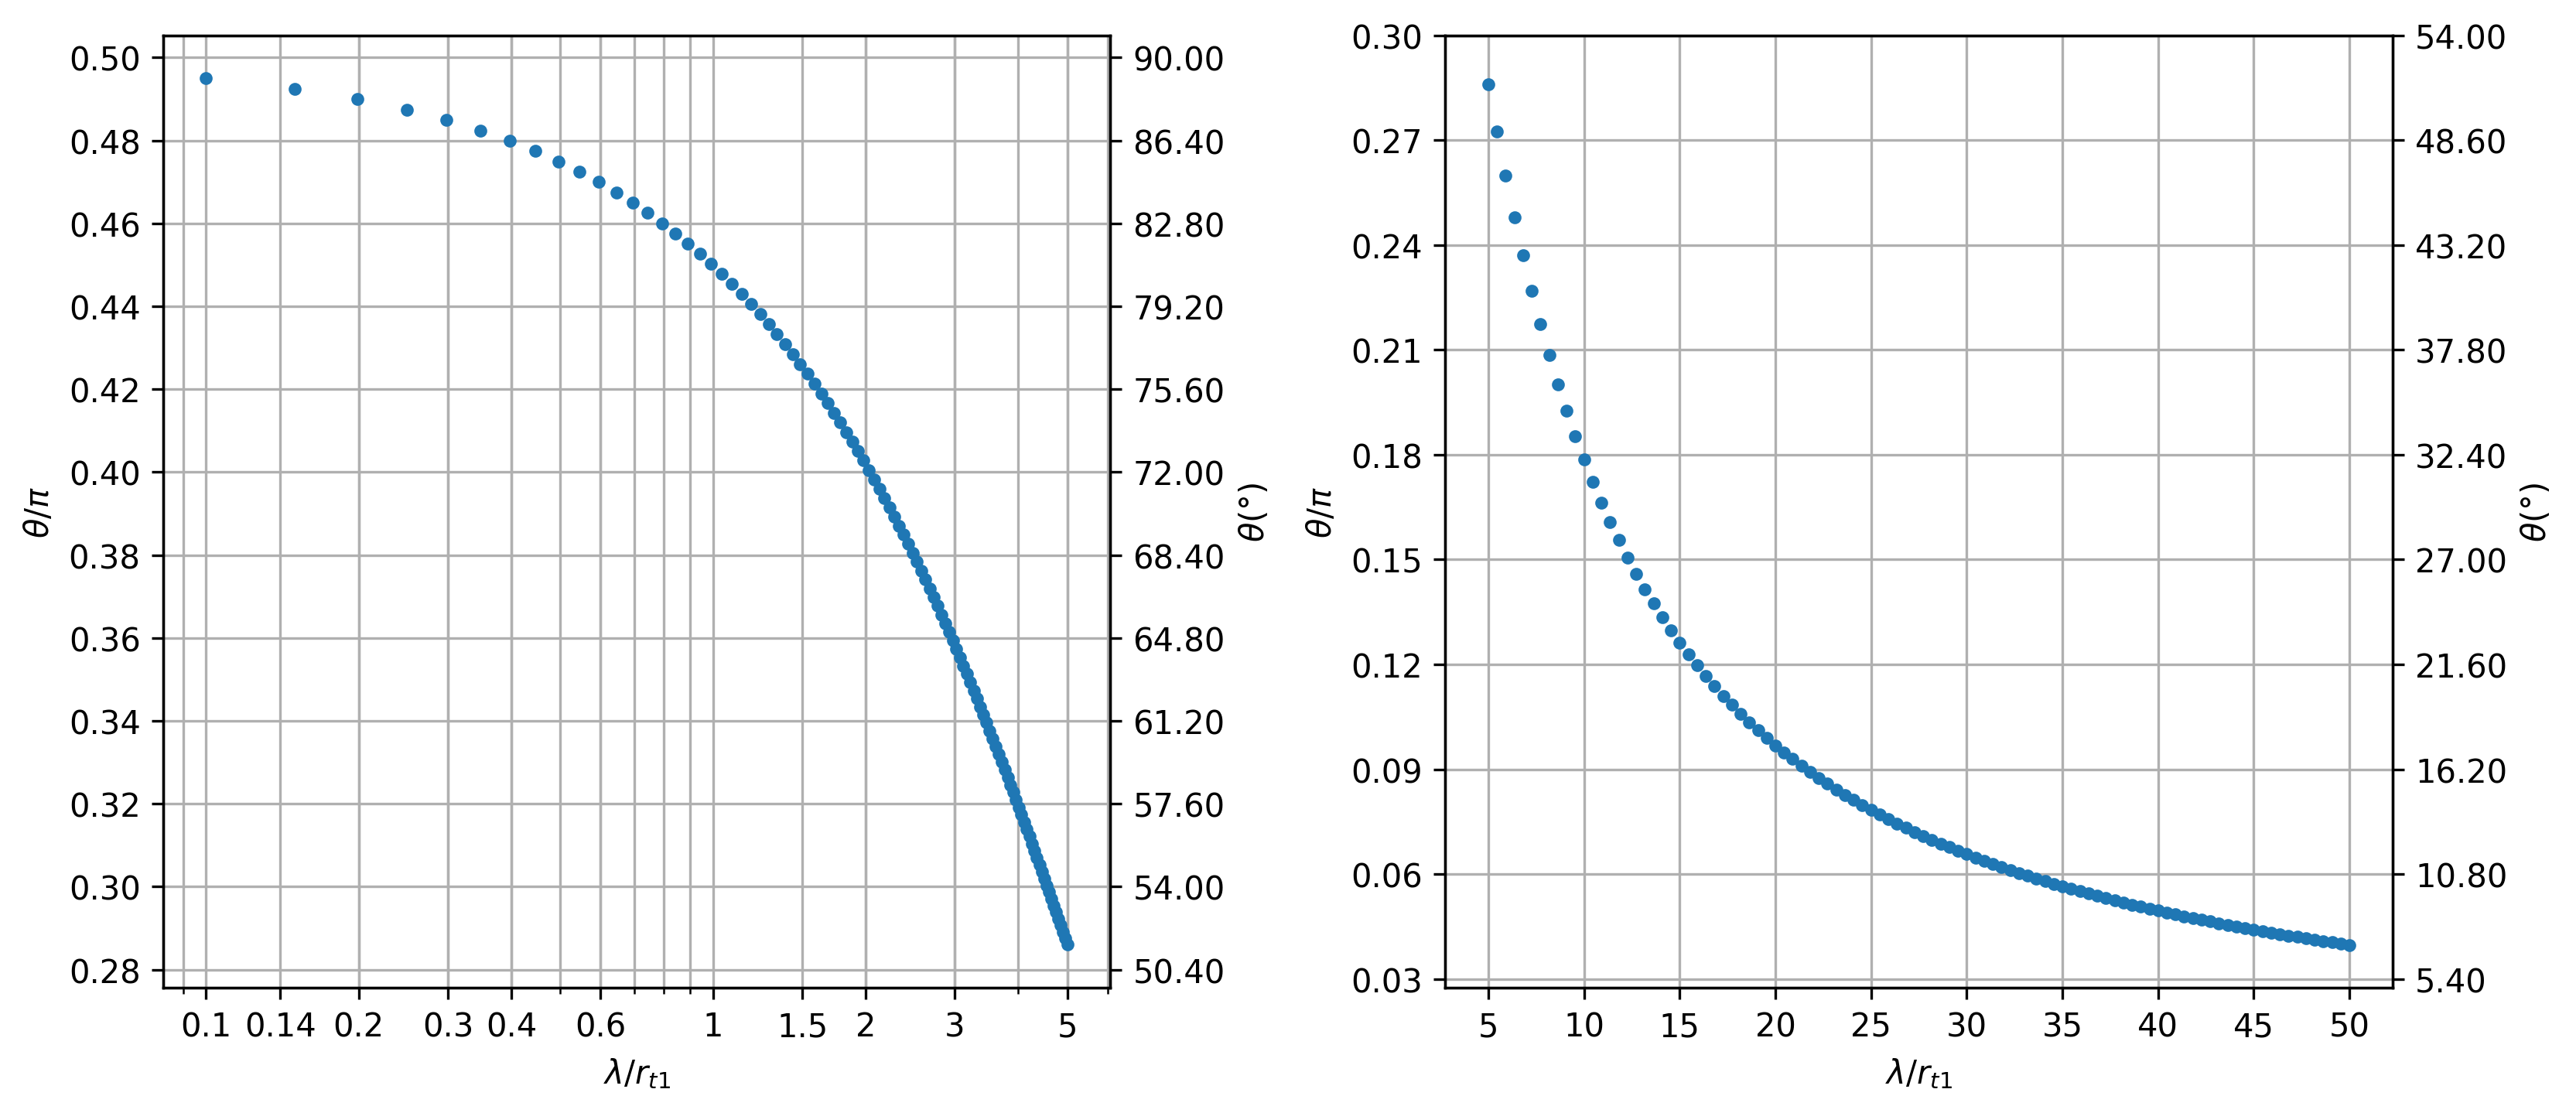

In [2]:
figsize = np.array((16, 7)) * 0.7
dpi = 300
rt1 = 1

fig, axs = plt.subplots(1, 2, figsize=figsize, dpi=dpi)
fig.patch.set_facecolor('white')
ax0 = axs[0]
ph = np.linspace(0.1, 5, 100)
theta = np.arctan((2 * np.pi * rt1) / ph) / np.pi
ax0.plot(ph, theta, '.')
ax0.set_xscale('log')
xticks = [0.1, 0.14, 0.2, 0.3, 0.4, 0.6, 1, 1.5, 2, 3, 5, ]
ax0.set_xticks(xticks)
ax0.set_xticklabels(xticks)
ax0.set_xlabel('$\\lambda / r_{t1}$')
yticks = np.linspace(0.28, 0.5, 12)
ax0.set_yticks(yticks)
ax0.set_yticklabels(['%.2f' % ti for ti in yticks])
ax0.set_ylabel('$\\theta / \\pi$')
ax0.grid(which='both')
ax02 = ax0.twinx()
yticks = np.array(yticks) * 180
ax02.set_yticks(yticks)
ax02.set_yticklabels(['%.2f' % ti for ti in yticks])
ax02.set_ylim(np.array(ax0.get_ylim()) * 180)
ax02.set_ylabel('$\\theta (\\degree)$')

ax1 = axs[1]
ph = np.linspace(5, 50, 100)
theta = np.arctan((2 * np.pi * rt1) / ph) / np.pi
ax1.plot(ph, theta, '.')
xticks = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50]
ax1.set_xticks(xticks)
ax1.set_xticklabels(xticks)
yticks = np.linspace(0.03, 0.3, 10)
ax1.set_yticks(yticks)
ax1.set_yticklabels(['%.2f' % ti for ti in yticks])
ax1.grid(which='both')
ax1.set_xlabel('$\\lambda / r_{t1}$')
ax1.set_ylabel('$\\theta / \\pi$')
ax12 = ax1.twinx()
yticks = np.array(yticks) * 180
ax12.set_yticks(yticks)
ax12.set_yticklabels(['%.2f' % ti for ti in yticks])
ax12.set_ylabel('$\\theta (\\degree)$')
ax12.set_ylim(np.array(ax1.get_ylim()) * 180)
plt.tight_layout()

In [6]:
use_node = 3
njob_node = 1
n_job_pbs = njob_node * use_node
random_order = True

def comm_infhelix_U(rh1, rh2, ph, ch, eh, nth, 
                    n_tail, ksp_max_it, f):
    ts = 'mpirun -np 24 python ../../infhelix_U.py '
    ts = ts + ' -rh1 %f -rh2 %f -ph %f -ch %f -eh %f -nth %d' % (rh1, rh2, ph, ch, eh, nth)
    ts = ts + ' -n_tail %d -ksp_max_it %d -f %s' % (n_tail, ksp_max_it, f)
    return ts

write_pbs_head = spf.write_pbs_head_q03
rh1, rh2, eh, nth = 1, 0.1, -1, 100
n_tail, ksp_max_it = 2, 100
ch_list = np.arange(1, 15.1).astype('int')
ph_list = np.arange(1, 6.1, 0.5)
job_dir = 'tail2/inf_a'
use_node = 6
n_job_pbs = 500
random_order = True

########################################################################################################
t_path = os.path.join(PWD, job_dir)
if not os.path.exists(t_path):
    os.makedirs(t_path)
# generate all comment file. 
ch_list, ph_list = np.meshgrid(ch_list, ph_list)
comm_list = []
txt_list = []
for i0, (chi, phi) in enumerate(zip(ch_list.ravel(), ph_list.ravel())):
    f = 'tail_ch%.2f_ph%.2f_n%d' % (chi, phi, n_tail)
    ts = comm_infhelix_U(rh1, rh2, phi, chi, eh, nth, 
                         n_tail, ksp_max_it, f)
    comm_list.append(ts)
    txt_list.append(f)
spf.write_main_run_comm_list(comm_list, txt_list, use_node, njob_node, job_dir, 
                             write_pbs_head, n_job_pbs, random_order=random_order)

exist folder /home/zhangji/stokes_flow_master/infhelix/tail2/inf_a
input 165 cases.
generate 1 pbs files in total.
 --->>random order mode is ON. 
Command of first case is:
mpirun -np 24 python ../../infhelix_U.py  -rh1 1.000000 -rh2 0.100000 -ph 1.000000 -ch 10.000000 -eh -1.000000 -nth 100 -n_tail 2 -ksp_max_it 100 -f tail_ch10.00_ph1.00_n2


True